# Clustering road sections with respective to the correlations of traffic flows
Shanshan Wang  
shanshan.wang@uni-due.de  
Dec.31, 2021

## Table of Contents
<div class="alert alert-block alert-info" style="margin-top: 20px">
<ol>
<li> <a href="#introduction">Introduction</a>
</li>
<li> <a href="#data"> Data</a><br>
        2.1 <a href="#dataset">Description of datasets</a><br>
        2.2 <a href="#dataclean">Data cleaning </a><br>
        2.3 <a href="#feature">Feature engineering</a><br>
        2.4 <a href="#datasummary">Summary of data exploration, data cleaning and feature engineering</a><br>
</li>
<li> <a href="#correlation"> Correlation matrices of traffic flows </a>
</li>
<li> <a href="#reduce"> Dimensionality reduction with PCA </a>
</li>
<li> <a href="#model">Clustering models</a><br>
        5.1 <a href="#kmeans"> $k$-means clustering</a><br>
        5.2 <a href="#hierarchical"> Hierarchical clustering</a><br>
        5.3 <a href="#dbscan"> DBSCAN clustering</a><br>
        5.4 <a href="#mean"> Mean shift clustering</a><br>
        5.5 <a href="#compare"> Comparison of clustering methods</a><br>
</li>
<li> <a href="#summary">Summary</a><br>
</li>
<li> <a href="#suggestion">Suggestions for next steps</a><br>
</li>
</ol>
</div>
    
    

       



## 1 Introduction <a name="introduction"></a>

Road sections in a traffic network manifest strong correlation of traffic flows, especially during the period of rush hours. Due to the correlations, classifying road sections into groups benifit the identification of traffic behavior of road sections based on the behavior of one or several road sections in the same group. The collective behavior of road sections in a group is of importance in implimenting traffic planning and managenment. Therefore, this report aims at clustering road sections with respect to the correlations of traffic flows. To this end, we work out the correlation matrix with the open dataset from [Ministry of Transport of the State of North Rhine-Westphalia (NRW), Germany](https://open.nrw/dataset/verkehrsz__hlung_in_nrw___jahresergebnis_2017_1568189625). After dimensional reduction of the correlation matrix, four clustering methods, including $k$-means clustering, hierarchical clustering, DBSCAN clustering and mean shift clustering, are applied to our data set and their clustering results are compared in terms of the silhouette values, which measures the cluster cohesion and separation. We summize our results and give the suggestions for next steps around this study. 


## 2 Data <a name="data"></a>

* <a href="#dataset">Section 2.1</a> briefs the used dataset, lists the dataset's attributes and show their data types. 
* <a href="#dataclean">Section 2.2</a> describes the data cleaning, including converting the numeric columns to floats, grouping and averaging the values by items, and removing the rows with missing values. 
* <a href="#feature">Section 2.3</a> explores the data features by visualizing the data matrix, displaying the relationships of different vechicle types and logarithmically transforming the data with large skewed values.
* <a href="#datasummary">Section 2.4</a> gives a short summary for data exploration, data cleaning and feature engineering.

### 2.1 Description of datasets <a name="dataset"></a>

This report uses the open dataset from [Ministry of Transport of the State of North Rhine-Westphalia (NRW), Germany](https://open.nrw/dataset/verkehrsz__hlung_in_nrw___jahresergebnis_2017_1568189625), with the [Data license Germany attribution 2.0](https://www.govdata.de/dl-de/by-2-0). It lists the annual results of traffic census in NRW during 2017. The attributes of the raw dataset are listed in Table 2, which contains the attributes' abbrivations, full names, units and data types. After data cleaning, **the used data attributes** are listed Table 3. The data is aggregated by counting station name (ZST_NAME) and street class and number (STRASSE), respectively, resulting a data matrix df3 and df4, which will be used for analysis.  

In [1]:
import pandas as pd
import numpy as np
import math

#### Table 1: the annual results of traffic census in NRW during 2017

In [2]:
df=pd.read_csv('https://open.nrw/sites/default/files/opendatafiles/180501_NW_Jahrestabelle_2017.csv', 
               sep=';',encoding='latin_1',header=1)
df.drop([0],inplace=True)
df.reset_index(drop=True,inplace=True)
df

ID STRASSE STR_KL  STR_NR STR_NR_ZUSATZ         ZST_NAME  TK_BLATT  \
0       5.0     A 1      A     1.0           NaN            Lotte     3.713   
1      10.0     A 1      A     1.0           NaN        Ladbergen     3.812   
2      20.0     A 1      A     1.0           NaN        Ascheberg     4.111   
3      25.0     A 1      A     1.0           NaN             Unna     4.411   
4      30.0     A 1      A     1.0           NaN          Hengsen     4.511   
..      ...     ...    ...     ...           ...              ...       ...   
337  2770.0   L 937      L   937.0           NaN      Detmold (S)     4.019   
338  2780.0   L 938      L   938.0           NaN      Detmold (W)     4.019   
339  2790.0   L 954      L   954.0           NaN      Bad Driburg     4.220   
340  2800.0    K 10      K    10.0           NaN   Sennestadt (O)  4017.000   
341  2810.0    K 10      K    10.0           NaN  Breckerfeld (O)  4710.000   

       ZST_NR     RICHTUNG_01      RICHTUNG_02  ... DTV_PKW_LFW_MOT DTV_PKW  \
0       5.143          Bremen          Münster  ...          59.364  53.019   
1       5.118          Bremen          Münster  ...          49.662  43.686   
2       5.121          Bremen             Köln  ...          55.362  50.779   
3       5.144         Münster             Köln  ...          97.513  88.203   
4       5.101  Kamen, Münster        Wuppertal  ...          89.824  81.237   
..        ...             ...              ...  ...             ...     ...   
337     5.518         Detmold        Schlangen  ...          13.973     NaN   
338     5.519         Detmold         Hiddesen  ...           9.517     NaN   
339     5.529     Bad Driburg          Warburg  ...           7.024    6506   
340  5521.000       Bielefeld    Oerlinghausen  ...            4367     NaN   
341  5508.000  Gloertalsperre  Ennepetalsperre  ...            2459     NaN   

    DTV_LFW DTV_MOT DTV_PKW_mit_Anh DTV_Bus DTV_LKW_ohne_Anh  \
0     6.151     194           1.371     191            1.943   
1     5.779     197           1.183     141            2.007   
2     4.461     122             914     124            2.011   
3     8.891     419           1.554     227            2.657   
4     8.107     480           1.378     197            4.005   
..      ...     ...             ...     ...              ...   
337     NaN     NaN              83      55              495   
338     NaN     NaN             100     608             1077   
339     439      79              85      61              280   
340     NaN     NaN             227       0               76   
341     NaN     NaN             123       1              120   

    DTV_LKW_mit_Anh_Sattel DTV_Sattel DTV_Sonstige  
0                   12.914     10.424            0  
1                    9.437      7.211          477  
2                    8.007      5.675        1.014  
3                   14.265     11.196            0  
4                   14.489     11.015        1.829  
..                     ...        ...          ...  
337                     11        NaN          213  
338                     47        NaN          146  
339                    137         75           12  
340                     44        NaN            0  
341                     58        NaN            0  

[342 rows x 28 columns]

#### Table 2: a summary of the dataset's attributes

In [3]:
df_legend=pd.read_csv('https://open.nrw/sites/default/files/opendatafiles/180501_NW_Jahrestabellen_2017_Legende.csv',
                      sep=';',encoding='latin_1')
df_attributes=df_legend[['Bezeichnung','Gegenstand','Dimension']].iloc[0:28,:]  
df_attributes['type']=df.dtypes.to_list()
df_attributes

Bezeichnung                                         Gegenstand  \
0                       ID  Sortierungsvariable (aufsteigende Straßenkateg...   
1                  STRASSE                           Straßenklasse und Nummer   
2                   STR_KL                                      Straßenklasse   
3                   STR_NR                                      Straßennummer   
4            STR_NR_ZUSATZ                                Straßennummerzusatz   
5                 ZST_NAME                                    Zählstellenname   
6                 TK_BLATT                                    TK-Blatt-Nummer   
7                   ZST_NR                                  Zählstellennummer   
8              RICHTUNG_01                             Richtungsbezeichnung_1   
9              RICHTUNG_02                             Richtungsbezeichnung_2   
10                 DTV_KFZ                  DTV KFZ Mo-So (Gesamtquerschnitt)   
11             DTVmofr_KFZ                  DTV KFZ Mo-Fr (Gesamtquerschnitt)   
12               DTVsa_KFZ                     DTV KFZ Sa (Gesamtquerschnitt)   
13               DTVso_KFZ                     DTV KFZ So (Gesamtquerschnitt)   
14                 DTV_SGV                  DTV SGV Mo-So (Gesamtquerschnitt)   
15                  DTV_SV                   DTV SV Mo-So (Gesamtquerschnitt)   
16              DTVmofr_SV                   DTV SV Mo-Fr (Gesamtquerschnitt)   
17                DTVsa_SV                      DTV SV Sa (Gesamtquerschnitt)   
18         DTV_PKW_LFW_MOT  DTV PKW/Lieferwagen/Motorräder Mo-So (Gesamtqu...   
19                 DTV_PKW                  DTV PKW Mo-So (Gesamtquerschnitt)   
20                 DTV_LFW          DTV Lieferwagen Mo-So (Gesamtquerschnitt)   
21                 DTV_MOT           DTV Motorräder Mo-So (Gesamtquerschnitt)   
22         DTV_PKW_mit_Anh     DTV Pkw mit Anhänger Mo-So (Gesamtquerschnitt)   
23                 DTV_Bus                  DTV Bus Mo-So (Gesamtquerschnitt)   
24        DTV_LKW_ohne_Anh      DTV LKW ohne Anhänger_Mo-So Gesamtquerschnitt   
25  DTV_LKW_mit_Anh_Sattel  DTV LKW mit Anhänger und Sattelzüge_Mo-So Gesa...   
26              DTV_Sattel             DTV Sattelzüge_Mo-So Gesamtquerschnitt   
27            DTV_Sonstige               DTV Sonstige_Mo-So Gesamtquerschnitt   

    Dimension     type  
0         NaN  float64  
1         NaN   object  
2         NaN   object  
3         NaN  float64  
4         NaN   object  
5         NaN   object  
6         NaN  float64  
7         NaN  float64  
8         NaN   object  
9         NaN   object  
10  [KFZ/24h]   object  
11  [KFZ/24h]   object  
12  [KFZ/24h]   object  
13  [KFZ/24h]   object  
14  [KFZ/24h]   object  
15  [KFZ/24h]   object  
16  [KFZ/24h]   object  
17  [KFZ/24h]   object  
18  [KFZ/24h]   object  
19  [KFZ/24h]   object  
20  [KFZ/24h]   object  
21  [KFZ/24h]   object  
22  [KFZ/24h]   object  
23  [KFZ/24h]   object  
24  [KFZ/24h]   object  
25  [KFZ/24h]   object  
26  [KFZ/24h]   object  
27  [KFZ/24h]   object

### 2.2 Data cleaning <a name="dataclean"></a>

The data cleaning for the used dataset is carried out by converting the data types of some variables, i.e., attributes, grouping with counting station name (ZST_NAME) and street class and number (STRASSE), respectively, and checking and removing the missing values.

In [4]:
# change the data types
df2=df.copy()
df2.iloc[:,[1,2,4,5,8,9]]=df.iloc[:,[1,2,4,5,8,9]].astype('string',copy=False)
df2.iloc[:,10:28]=df.iloc[:,10:28].astype('float64',copy=False)
df2.drop(['ID','STR_NR_ZUSATZ','STR_KL','STR_NR','TK_BLATT','ZST_NR'],inplace=True,axis=1)
df2.describe()

DTV_KFZ   DTVmofr_KFZ     DTVsa_KFZ     DTVso_KFZ       DTV_SGV  \
count    341.000000    341.000000    341.000000    341.000000    339.000000   
mean     143.951516    162.058554    117.628396     94.911223    285.593041   
std     1321.034589   1512.193497   1044.156382    807.249933    805.148107   
min        1.632000      1.647000      1.434000      1.374000      1.009000   
25%        9.644000     10.646000      8.008000      6.342000      6.806500   
50%       29.158000     31.420000     23.240000     18.925000     17.586000   
75%       75.697000     81.721000     64.526000     54.414000    372.000000   
max    23590.000000  26998.000000  18623.000000  14371.000000  12747.000000   

            DTV_SV   DTVmofr_SV     DTVsa_SV  DTV_PKW_LFW_MOT       DTV_PKW  \
count   339.000000   341.000000   341.000000       339.000000    323.000000   
mean    265.519622   334.917185   159.866798       295.728891    312.230529   
std     454.349521   721.708356   247.228792      3253.154933   2100.420417   
min       1.093000     1.089000     1.017000         1.514000      1.258000   
25%       6.905000     8.431000     4.080000         8.676000      8.396500   
50%      16.478000    18.880000    72.000000        22.993000     25.188000   
75%     401.000000   476.000000   206.000000        65.821500     62.091500   
max    3479.000000  8891.000000  2251.000000     55406.000000  27063.000000   

           DTV_LFW      DTV_MOT  DTV_PKW_mit_Anh     DTV_Bus  \
count   323.000000   323.000000       339.000000  339.000000   
mean    300.872659   213.245867       274.359814   92.235988   
std     443.682714   187.464179       280.342760   83.343361   
min       1.090000     1.704000         1.006000    0.000000   
25%       5.247000    89.000000        62.000000   29.500000   
50%      10.028000   148.000000       145.000000   62.000000   
75%     512.000000   289.500000       474.500000  130.000000   
max    2988.000000  1552.000000      1274.000000  608.000000   

       DTV_LKW_ohne_Anh  DTV_LKW_mit_Anh_Sattel   DTV_Sattel  DTV_Sonstige  
count        339.000000              339.000000   323.000000    339.000000  
mean         213.789903              193.156590   171.324372    173.691655  
std          362.188630              523.662929   305.198408    272.616367  
min            1.016000                0.000000     1.068000      0.000000  
25%            2.472000                5.834000     5.413500      0.000000  
50%          109.000000               16.000000    27.000000     23.000000  
75%          283.000000              227.000000   204.500000    258.000000  
max         4716.000000             8031.000000  2477.000000   1105.000000

In [5]:
idx=[]
for x in ['ID','STR_NR_ZUSATZ','STR_KL','STR_NR','TK_BLATT','ZST_NR']:
    idx.append(df_attributes[df_attributes['Bezeichnung']==x].index[0].tolist())
idx

[0, 4, 2, 3, 6, 7]

#### Table 3: a summary of used data attributes

In [6]:
df2_attributes=df_attributes.copy()
df2_attributes.drop(index=idx,inplace=True)
df2_attributes.drop(columns=['type'],inplace=True)
df2_attributes['type']=df2.dtypes.to_list()
df2_attributes.reset_index(drop=True,inplace=True)
df2_attributes

Bezeichnung                                         Gegenstand  \
0                  STRASSE                           Straßenklasse und Nummer   
1                 ZST_NAME                                    Zählstellenname   
2              RICHTUNG_01                             Richtungsbezeichnung_1   
3              RICHTUNG_02                             Richtungsbezeichnung_2   
4                  DTV_KFZ                  DTV KFZ Mo-So (Gesamtquerschnitt)   
5              DTVmofr_KFZ                  DTV KFZ Mo-Fr (Gesamtquerschnitt)   
6                DTVsa_KFZ                     DTV KFZ Sa (Gesamtquerschnitt)   
7                DTVso_KFZ                     DTV KFZ So (Gesamtquerschnitt)   
8                  DTV_SGV                  DTV SGV Mo-So (Gesamtquerschnitt)   
9                   DTV_SV                   DTV SV Mo-So (Gesamtquerschnitt)   
10              DTVmofr_SV                   DTV SV Mo-Fr (Gesamtquerschnitt)   
11                DTVsa_SV                      DTV SV Sa (Gesamtquerschnitt)   
12         DTV_PKW_LFW_MOT  DTV PKW/Lieferwagen/Motorräder Mo-So (Gesamtqu...   
13                 DTV_PKW                  DTV PKW Mo-So (Gesamtquerschnitt)   
14                 DTV_LFW          DTV Lieferwagen Mo-So (Gesamtquerschnitt)   
15                 DTV_MOT           DTV Motorräder Mo-So (Gesamtquerschnitt)   
16         DTV_PKW_mit_Anh     DTV Pkw mit Anhänger Mo-So (Gesamtquerschnitt)   
17                 DTV_Bus                  DTV Bus Mo-So (Gesamtquerschnitt)   
18        DTV_LKW_ohne_Anh      DTV LKW ohne Anhänger_Mo-So Gesamtquerschnitt   
19  DTV_LKW_mit_Anh_Sattel  DTV LKW mit Anhänger und Sattelzüge_Mo-So Gesa...   
20              DTV_Sattel             DTV Sattelzüge_Mo-So Gesamtquerschnitt   
21            DTV_Sonstige               DTV Sonstige_Mo-So Gesamtquerschnitt   

    Dimension     type  
0         NaN   string  
1         NaN   string  
2         NaN   string  
3         NaN   string  
4   [KFZ/24h]  float64  
5   [KFZ/24h]  float64  
6   [KFZ/24h]  float64  
7   [KFZ/24h]  float64  
8   [KFZ/24h]  float64  
9   [KFZ/24h]  float64  
10  [KFZ/24h]  float64  
11  [KFZ/24h]  float64  
12  [KFZ/24h]  float64  
13  [KFZ/24h]  float64  
14  [KFZ/24h]  float64  
15  [KFZ/24h]  float64  
16  [KFZ/24h]  float64  
17  [KFZ/24h]  float64  
18  [KFZ/24h]  float64  
19  [KFZ/24h]  float64  
20  [KFZ/24h]  float64  
21  [KFZ/24h]  float64

#### Table 4: data of road sections

In [7]:
df3=df2.groupby(['ZST_NAME']).mean()
df3.head()

DTV_KFZ  DTVmofr_KFZ  DTVsa_KFZ  DTVso_KFZ  DTV_SGV  \
ZST_NAME                                                                   
AD Bonn-Nordost (N)  120.127      134.011     97.080     84.835    7.454   
AD Bonn-Nordost (S)   88.024      100.522     66.545     56.852    3.443   
AD Bonn-Nordost (W)   98.699      109.482     82.359     70.025    6.698   
AD Essen-Ost (O)     122.509      132.714    114.031     89.698    8.051   
AD Essen-Ost (S)      60.391       67.577     45.811     44.276    3.692   

                     DTV_SV  DTVmofr_SV  DTVsa_SV  DTV_PKW_LFW_MOT  DTV_PKW  \
ZST_NAME                                                                      
AD Bonn-Nordost (N)   7.753      10.298     3.331          110.475  101.790   
AD Bonn-Nordost (S)   3.588       4.806     1.470           83.724   77.314   
AD Bonn-Nordost (W)   6.918       9.243     2.861           89.982   82.141   
AD Essen-Ost (O)      8.275      11.137     3.022          113.139  105.280   
AD Essen-Ost (S)      3.771       5.165     1.118           56.090   52.105   

                     DTV_LFW  DTV_MOT  DTV_PKW_mit_Anh  DTV_Bus  \
ZST_NAME                                                          
AD Bonn-Nordost (N)    8.252    433.0            823.0    299.0   
AD Bonn-Nordost (S)    6.050    360.0            412.0    145.0   
AD Bonn-Nordost (W)    7.318    523.0            785.0    220.0   
AD Essen-Ost (O)       7.616    243.0            535.0    224.0   
AD Essen-Ost (S)       3.853    132.0            298.0     79.0   

                     DTV_LKW_ohne_Anh  DTV_LKW_mit_Anh_Sattel  DTV_Sattel  \
ZST_NAME                                                                    
AD Bonn-Nordost (N)             3.133                   4.321       3.412   
AD Bonn-Nordost (S)             2.133                   1.310     918.000   
AD Bonn-Nordost (W)             2.749                   3.949       3.184   
AD Essen-Ost (O)                3.109                   4.942       4.061   
AD Essen-Ost (S)                1.534                   2.158       1.701   

                     DTV_Sonstige  
ZST_NAME                           
AD Bonn-Nordost (N)        1077.0  
AD Bonn-Nordost (S)         299.0  
AD Bonn-Nordost (W)        1014.0  
AD Essen-Ost (O)            560.0  
AD Essen-Ost (S)            232.0

In [8]:
df3.shape

(341, 18)

In [9]:
# check missing value
df3.isna().sum(axis=0)

DTV_KFZ                    0
DTVmofr_KFZ                0
DTVsa_KFZ                  0
DTVso_KFZ                  0
DTV_SGV                    2
DTV_SV                     2
DTVmofr_SV                 0
DTVsa_SV                   0
DTV_PKW_LFW_MOT            2
DTV_PKW                   18
DTV_LFW                   18
DTV_MOT                   18
DTV_PKW_mit_Anh            2
DTV_Bus                    2
DTV_LKW_ohne_Anh           2
DTV_LKW_mit_Anh_Sattel     2
DTV_Sattel                18
DTV_Sonstige               2
dtype: int64

In [10]:
# remove missing values
df3.dropna(inplace=True)
df3.shape

(323, 18)

In [11]:
# check missing values again
df3.isna().sum(axis=0).sum()

0

#### Table 5: data of motorways

In [12]:
df4=df2.groupby(['STRASSE']).mean()
df4.head()

DTV_KFZ  DTVmofr_KFZ   DTVsa_KFZ  DTVso_KFZ    DTV_SGV     DTV_SV  \
STRASSE                                                                         
A 1       77.569071    81.277714   70.564143  68.831571   9.567929   9.682143   
A 2       93.449500   101.295000   79.981750  73.868000  16.646875  16.828125   
A 3      110.086667   115.281333  102.781952  95.811238  13.143429  13.365667   
A 30      44.595500    48.739000   38.420000  33.493500   9.248500   9.368500   
A 31      33.046000    34.343000   30.403000  30.149000   4.220000   4.277000   

         DTVmofr_SV  DTVsa_SV  DTV_PKW_LFW_MOT    DTV_PKW   DTV_LFW  \
STRASSE                                                               
A 1       12.910071  3.891857         66.59950  60.104857  6.153571   
A 2       22.437750  7.340500         75.15825  68.299200  7.852000   
A 3       17.633143  5.959524         95.02300  85.738667  8.861762   
A 30      12.230000  4.955000         34.15850  30.640000  3.254000   
A 31       5.851000  1.074000         28.16500  25.188000  2.956000   

            DTV_MOT  DTV_PKW_mit_Anh     DTV_Bus  DTV_LKW_ohne_Anh  \
STRASSE                                                              
A 1      341.071429       371.351143  114.214286        117.434857   
A 2      336.200000       207.287250  181.250000          3.483750   
A 3      341.509714       221.048286  222.238095         36.174952   
A 30     264.500000       667.000000  120.000000          1.369000   
A 31      21.000000       580.000000   57.000000        650.000000   

         DTV_LKW_mit_Anh_Sattel  DTV_Sattel  DTV_Sonstige  
STRASSE                                                    
A 1                    7.660286    5.962929    148.345929  
A 2                   13.163125   10.585000    344.625000  
A 3                   10.030619    8.126524    400.553048  
A 30                   7.879500    6.465000    401.000000  
A 31                   3.570000    2.789000     24.000000

In [13]:
# check missing value
df4.isna().sum(axis=0)

DTV_KFZ                   0
DTVmofr_KFZ               0
DTVsa_KFZ                 0
DTVso_KFZ                 0
DTV_SGV                   0
DTV_SV                    0
DTVmofr_SV                0
DTVsa_SV                  0
DTV_PKW_LFW_MOT           0
DTV_PKW                   8
DTV_LFW                   8
DTV_MOT                   8
DTV_PKW_mit_Anh           0
DTV_Bus                   0
DTV_LKW_ohne_Anh          0
DTV_LKW_mit_Anh_Sattel    0
DTV_Sattel                8
DTV_Sonstige              0
dtype: int64

In [14]:
# remove missing values
df4.dropna(inplace=True)
df4.shape

(127, 18)

In [15]:
# check missing values again
df4.isna().sum(axis=0).sum()

0

Now data frames df3 for the data of road sections and df4 for the data of motorways are clearned for using. In the following, we will focus on the data matrix df3 with 18 attributes as columns and 323 counting stations, representing 323 road sections, as rows.

### 2.3 Feature engineering <a name="feature"></a>

Feature engineering is performed by visualizing the data matrix, displaying the relationship of six vechicle types, examing the skew values and logarithmically tranforming the highly skewed variables.

In [16]:
import seaborn as sns
from scipy import stats 
from scipy.stats import norm, expon, cauchy
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

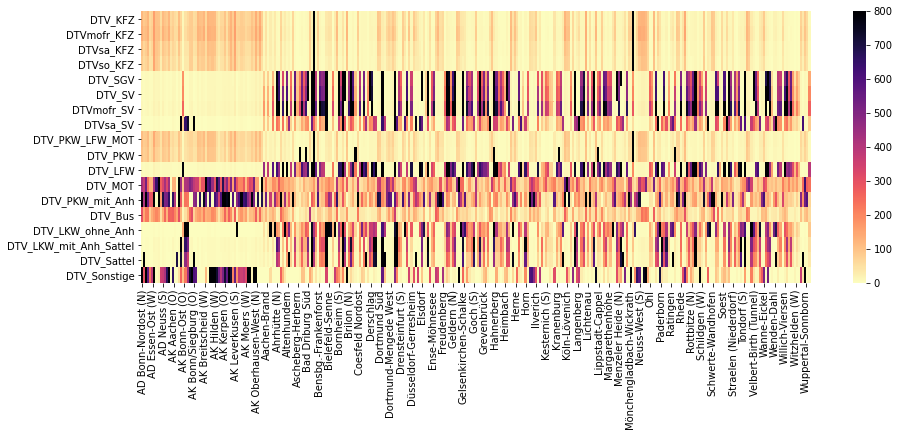

In [17]:
# data matrix of transpose of df3
ax = plt.subplots(figsize=(15, 5))
ax=sns.heatmap(df3.T,cmap="magma_r", vmin=0, vmax=800).set(ylabel='',xlabel='')

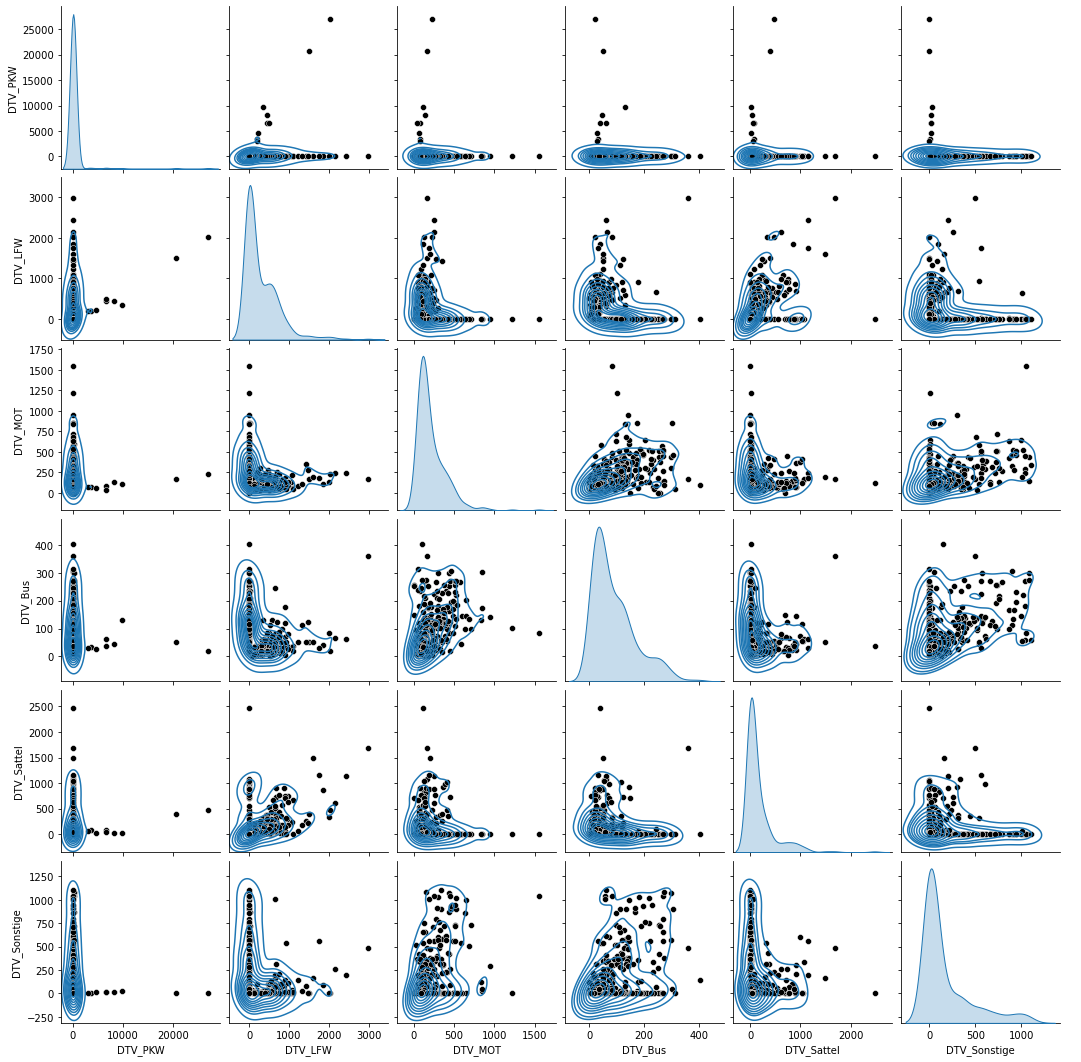

In [18]:
# draw the relationship of six vechicle types both by scatter plots and kernel density estimate (KDE)
vechicle=df3[['DTV_PKW','DTV_LFW','DTV_MOT','DTV_Bus','DTV_Sattel','DTV_Sonstige']]
g = sns.pairplot(vechicle, kind="kde", height=2.5)
g.map_upper(sns.scatterplot,color="k")
g.map_lower(sns.scatterplot,color="k")
g.add_legend()

#### Examine the skew values and log transform 

In [19]:
# Examine the skew values
log_columns=df3.skew().sort_values(ascending=False)
log_columns=log_columns.loc[log_columns>0.75]
log_columns

DTVmofr_KFZ               17.438451
DTV_PKW_LFW_MOT           17.425602
DTV_KFZ                   17.408389
DTVsa_KFZ                 17.330763
DTVso_KFZ                 17.256725
DTV_PKW                    9.961022
DTVmofr_SV                 6.351321
DTV_SV                     3.402798
DTV_SGV                    3.401358
DTVsa_SV                   3.239035
DTV_Sattel                 3.092812
DTV_LKW_mit_Anh_Sattel     3.043798
DTV_MOT                    2.573134
DTV_LFW                    2.315870
DTV_Sonstige               1.822339
DTV_LKW_ohne_Anh           1.798893
DTV_Bus                    1.222112
DTV_PKW_mit_Anh            1.087287
dtype: float64

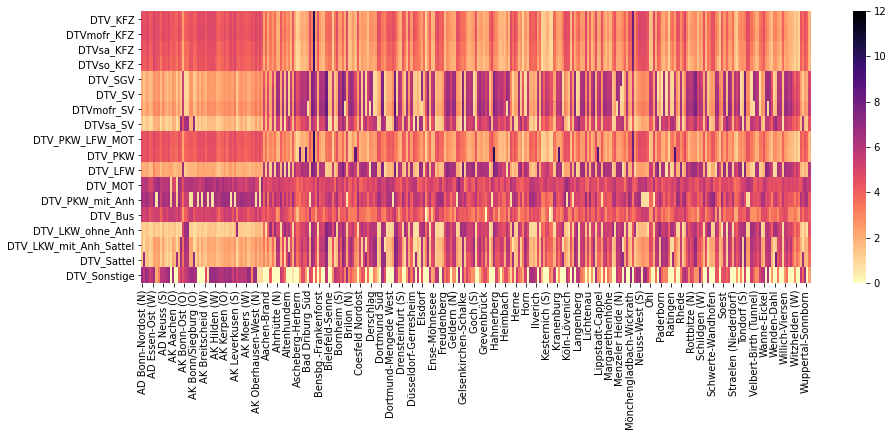

In [20]:
# The log transforms
df6=df3.copy()
for col in log_columns.index:
    df6[col]=np.log1p(df6[col])

# scale the data again
# mms=MinMaxScaler()
# for col in df6.columns:
    # df6[col]=mms.fit_transform(df6[[col]])
    
# data matrix of transpose of df6
ax = plt.subplots(figsize=(15, 5))
ax=sns.heatmap(df6.T,cmap="magma_r", vmin=0, vmax=12).set(ylabel='',xlabel='')

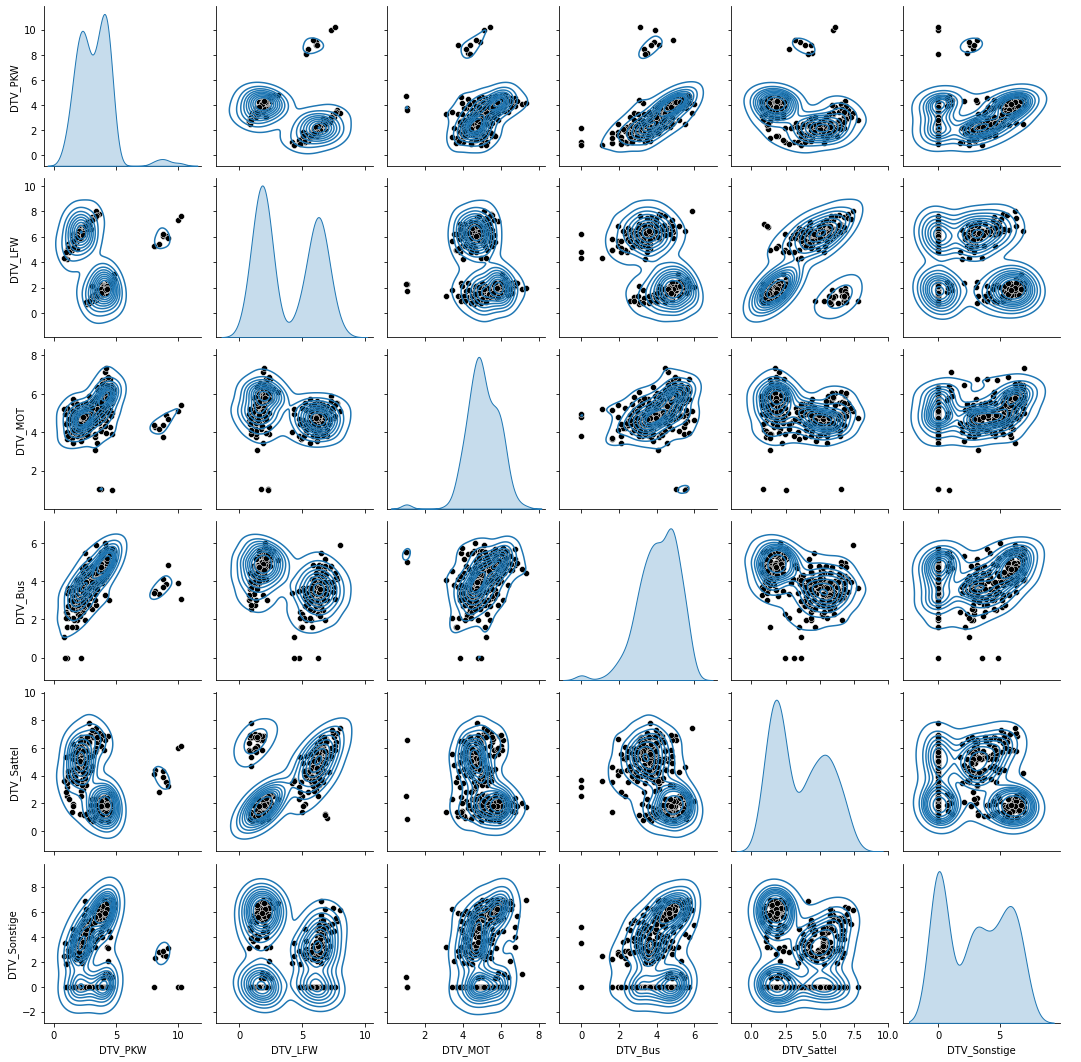

In [21]:
vechicle=df6[['DTV_PKW','DTV_LFW','DTV_MOT','DTV_Bus','DTV_Sattel','DTV_Sonstige']]
g = sns.pairplot(vechicle, kind="kde", height=2.5)
g.map_upper(sns.scatterplot,color="k")
g.map_lower(sns.scatterplot,color="k")
g.add_legend()

In [22]:
df5=df[['STR_KL','ZST_NAME']]
df5.merge(df6, how='inner', on='ZST_NAME')
df5.groupby(['STR_KL']).agg(','.join)

ZST_NAME
STR_KL                                                   
A       Lotte,Ladbergen,Ascheberg,Unna,Hengsen,Hagen-V...
B       Düsseldorf-Heerdt,AK Bonn-Ost (S),Aachen-Vaals...
K                          Sennestadt (O),Breckerfeld (O)
L       Werl-Westönnen,Loope,Stromberg,Greven (S),Woll...

### 2.4 Summary of data exploration, data cleaning and feature engineering<a name="datasummary"></a>

The raw dataset includes 342 rows of items and 28 columns of attributes. Wrong data types and missing values are present in some attributes, which can not be used directly. Therefore, data cleaning is required so as to make data availbe for analysis. 

To this end, we converted the attributes with wrong data types to the corrected types, selected the useful attributes, aggregated the data by counting station name (ZST_NAME) and street class and number (STRASSE), respectively, and removed the rows of the data matrix with missing values. The resulting data matrix includes 323 rows of items and 18 columns of attributes. The attributes are also the variables for each item of each row.     

The feature enginering reveals a large difference is present among attributes in each column. We thus examined the skew values and picked out attributes with the skew values larger than 0.75. For those attributes, a logarithmical transformation is applied to them. In this way, all attributes have the similar scale and are comparable.  


## 3 Correlation matrices of traffic flows<a name="correlation"></a>

This section compares the correlation matrices of traffic flows before and after the logarithmically transforming the highly skewed variables. To this end, we carried out following steps:
* Draw correlation matrix before and after the logarithmically transformation.
* Draw histogram of correlation and fit it by normal, exponential and Cauchy-Lorentz distributions.
* Perform hypothesis tests for the normality of correlations by the Shapiro-Wilk Normality Test and Anderson-Darling Test.
* Reorder the correlation matrix by a clustered heatmap with dendrograms.
* Find out the most strongly correlated station for each road section (counting station). 

The results can be concluded as follows:

The vechicle flows show strong correlation among different road sections, represented by counting stations. The logarithmical transformation makes all variables in the similar scale and comparable. It also makes the correlations stronger than the original ones. The distribution of correlations approaches to the Cauchy-Lorentz distribution for small values before transformations, but to the exponential distributions for small values after transformations. The Shapiro-Wilk normality test and Anderson-Darling test for the distribution of correlations demonstrate that the elements in the correlation matrices are non-Gaussian distributed. Reordering the counting stations and displaying them in a clustered heatmap, the strongly correlated groups are remarkable in the diagonal blocks in each correlation matrix. After logarithmical transformation, the strongly correlated groups are more significant and distinguishable with the weakly correlated groups. By locating the maximal absolute correlation, the section that most strongly correlated with each road section can be found out. 



[Text(804.6167613636362, 0.5, ''),
 Text(0.5, 39.453125, ''),
 Text(0.5, 1.0, 'after logarithmical transformations')]

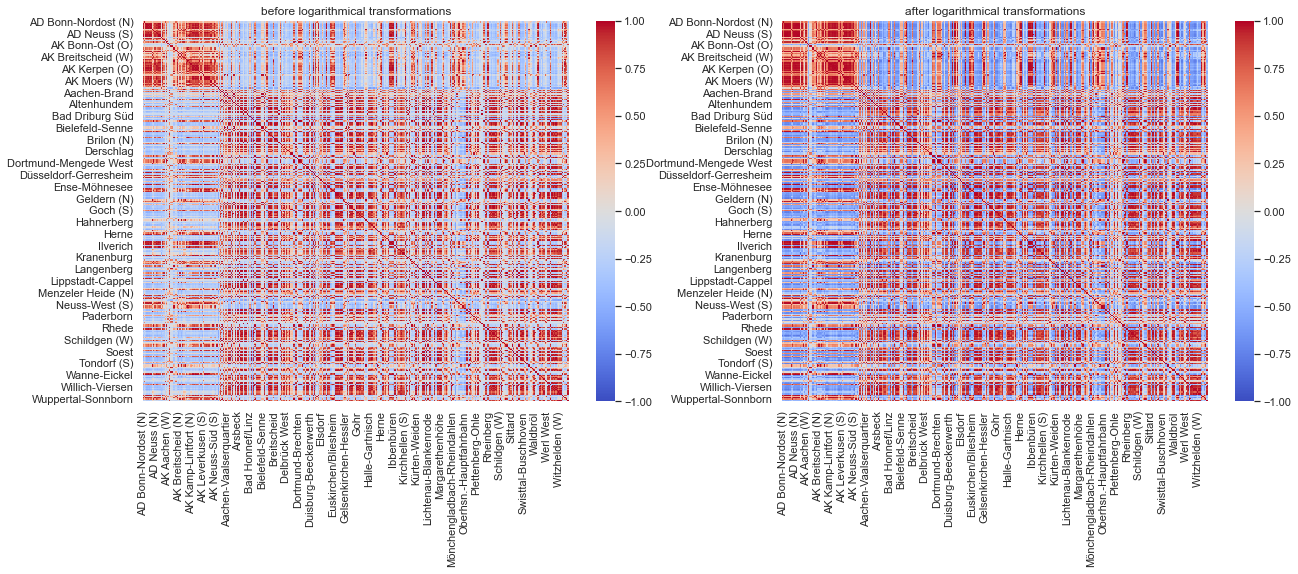

In [23]:
# correlation matrix before log transforms
sns.set(font_scale=1)
fig,axes=plt.subplots(1,2,figsize=(21, 7))
stcorr=df3.T.corr()
sns.heatmap(stcorr,cmap="coolwarm", vmin=-1, vmax=1, ax=axes[0]).set(ylabel='',xlabel='',title='before logarithmical transformations')
# correlation matrix after log transforms
stcorr_df6=df6.T.corr()
sns.heatmap(stcorr_df6,cmap="coolwarm", vmin=-1, vmax=1,ax=axes[1]).set(ylabel='',xlabel='',title='after logarithmical transformations')


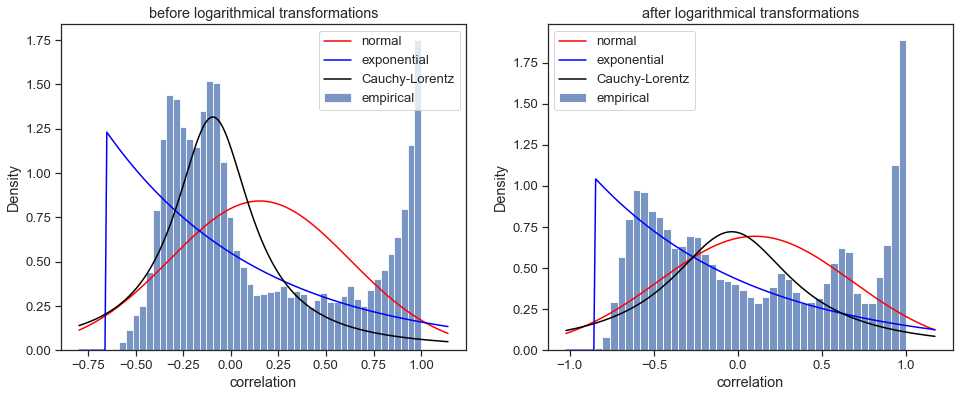

In [24]:
# draw histogram of correlation and fit it by normal, exponential and Cauchy-Lorentz distributions
sns.set(font_scale=1.2)
sns.set_style("ticks")
fig,axes=plt.subplots(1,2,figsize=(16, 6))
sns.histplot(stcorr.values.flatten(),stat='density',label='empirical', ax=axes[0]).set(xlabel='correlation')
sns.distplot(stcorr.values.flatten(), fit=norm, hist=False, kde=False,label='normal',fit_kws={"color":"red"}, ax=axes[0])
sns.distplot(stcorr.values.flatten(), fit=expon, hist=False, kde=False,label='exponential',fit_kws={"color":"blue"}, ax=axes[0])
sns.distplot(stcorr.values.flatten(), fit=cauchy, hist=False, kde=False,label='Cauchy-Lorentz',fit_kws={"color":"black"}, ax=axes[0])
axes[0].legend()
axes[0].set_title('before logarithmical transformations')

# draw histogram of correlation
sns.histplot(stcorr_df6.values.flatten(),stat='density',label='empirical', ax=axes[1]).set(xlabel='correlation')
sns.distplot(stcorr_df6.values.flatten(), fit=norm, hist=False, kde=False,label='normal',fit_kws={"color":"red"}, ax=axes[1])
sns.distplot(stcorr_df6.values.flatten(), fit=expon, hist=False, kde=False,label='exponential',fit_kws={"color":"blue"}, ax=axes[1])
sns.distplot(stcorr_df6.values.flatten(), fit=cauchy, hist=False, kde=False,label='Cauchy-Lorentz',fit_kws={"color":"black"}, ax=axes[1])
axes[1].legend()
axes[1].set_title('after logarithmical transformations')
plt.show()

In [25]:
# Hypothesis tests 
# The Shapiro-Wilk Normality Test
# H0: The correlations of counting stations follows a Gaussian distribution
# H1: The correlations of counting stations do not follow a Gaussian distribution

from scipy.stats import shapiro
stat, p = shapiro(stcorr.values.flatten())
print('Before log transform:\n')
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')
    
stat, p = shapiro(stcorr_df6.values.flatten())
print('\nAfter log transform:\n')
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

Before log transform:

stat=0.876, p=0.000
Probably not Gaussian

After log transform:

stat=0.910, p=0.000
Probably not Gaussian


In [26]:
# Anderson-Darling Test
# H0: the sample has a Gaussian distribution.
# H1: the sample does not have a Gaussian distribution.
    
from scipy.stats import anderson
result = anderson(stcorr.values.flatten())
print('Before log transform:\n')
print('stat=%.3f' % (result.statistic))
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print('Probably Gaussian at the %.1f%% level' % (sl))
    else:
        print('Probably not Gaussian at the %.1f%% level' % (sl))
        
result = anderson(stcorr_df6.values.flatten())
print('\nAfter log transform:\n')
print('stat=%.3f' % (result.statistic))
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print('Probably Gaussian at the %.1f%% level' % (sl))
    else:
        print('Probably not Gaussian at the %.1f%% level' % (sl))

Before log transform:

stat=4945.750
Probably not Gaussian at the 15.0% level
Probably not Gaussian at the 10.0% level
Probably not Gaussian at the 5.0% level
Probably not Gaussian at the 2.5% level
Probably not Gaussian at the 1.0% level

After log transform:

stat=3001.248
Probably not Gaussian at the 15.0% level
Probably not Gaussian at the 10.0% level
Probably not Gaussian at the 5.0% level
Probably not Gaussian at the 2.5% level
Probably not Gaussian at the 1.0% level


Text(0.5, 1.0, 'after logarithmical transformations')

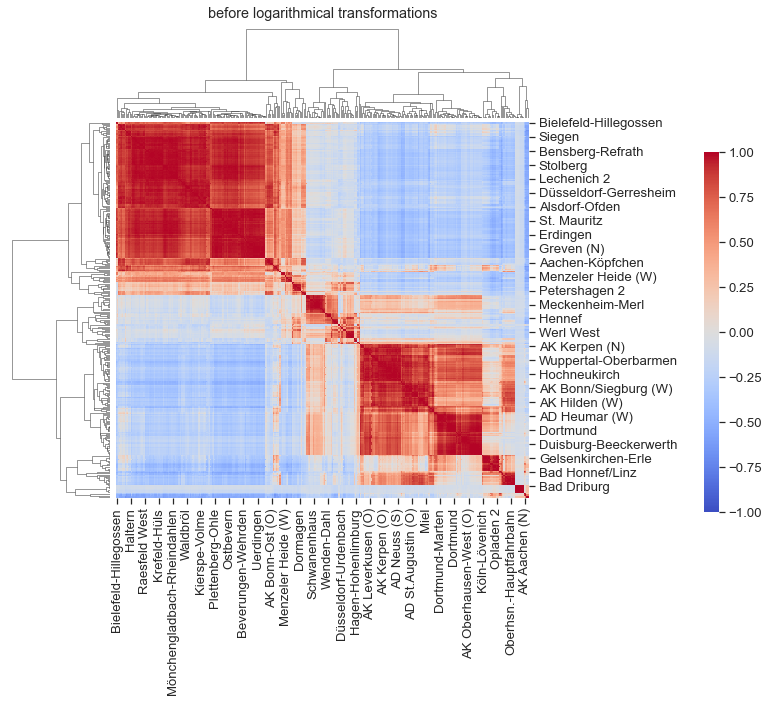

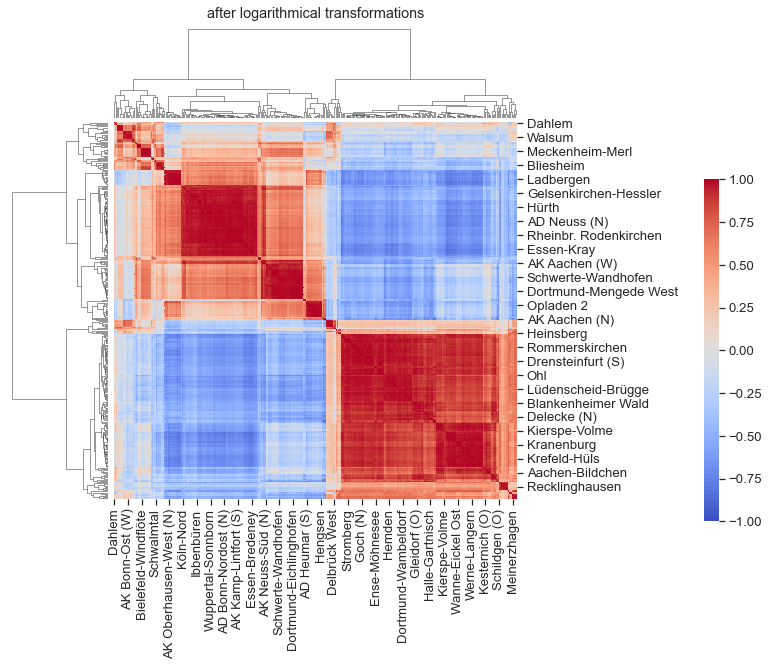

In [27]:
# reorder the correlation matrix by a clustered heatmap with dendrograms
axes[0]=sns.clustermap(stcorr, figsize=(10,10), cmap="coolwarm", vmin=-1, vmax=1, cbar_pos=(0.99, .3, .02, .5))
axes[0].ax_heatmap.set_xlabel('')
axes[0].ax_heatmap.set_ylabel('')
axes[0].ax_col_dendrogram.set_title('before logarithmical transformations')

axes[1]=sns.clustermap(stcorr_df6, figsize=(10,9.5), cmap="coolwarm", vmin=-1, vmax=1, cbar_pos=(0.99, .25, .02, .5))
axes[1].ax_heatmap.set_xlabel('')
axes[1].ax_heatmap.set_ylabel('')
axes[1].ax_col_dendrogram.set_title('after logarithmical transformations')

In [28]:
# find out each raod section (counting station) with their most strongly correlated variable (station)
stcorr0=stcorr.copy()
for i in range(stcorr0.shape[0]):
    stcorr0.iloc[i,i]=0    
corrpair=stcorr0.abs().idxmax().to_frame()
corrpair.rename(columns={0:'before logarithmical transformations'},inplace=True)

stcorr0_df6=stcorr_df6.copy()
for i in range(stcorr0_df6.shape[0]):
    stcorr0_df6.iloc[i,i]=0    
corrpair['after logarithmical transformations']=stcorr0_df6.abs().idxmax().to_frame()
corrpair


before logarithmical transformations  \
ZST_NAME                                                    
AD Bonn-Nordost (N)                    AD St.Augustin (O)   
AD Bonn-Nordost (S)                        AK Aachen (SW)   
AD Bonn-Nordost (W)                    AD St.Augustin (O)   
AD Essen-Ost (O)                         AD Essen-Ost (W)   
AD Essen-Ost (S)                         Düsseldorf-Flehe   
...                                                   ...   
Wuppertal-Oberbarmen                          Freudenberg   
Wuppertal-Saurenhaus                 Düsseldorf-Urdenbach   
Wuppertal-Sonnborn                          AK Hilden (O)   
Würselen                                     Aachen-Brand   
Zweifall                                  Wollersheim (O)   

                     after logarithmical transformations  
ZST_NAME                                                  
AD Bonn-Nordost (N)                   AD St.Augustin (S)  
AD Bonn-Nordost (S)                        Engelskirchen  
AD Bonn-Nordost (W)                 AK Bonn/Siegburg (W)  
AD Essen-Ost (O)                        AD Essen-Ost (W)  
AD Essen-Ost (S)                                Ilverich  
...                                                  ...  
Wuppertal-Oberbarmen                          Eckenhagen  
Wuppertal-Saurenhaus                AK Bonn/Siegburg (O)  
Wuppertal-Sonnborn                         AK Hilden (O)  
Würselen                              Schwerte-Wandhofen  
Zweifall                                           Loope  

[323 rows x 2 columns]

## 4 Dimensionality reduction with PCA<a name="reduce"></a>

In this section, we will reduce the dimentions of the $323\times 323$ correlation matrix, i.e., stcorr_df6, resulting from the logarithmically transformed data of traffic flows in the following way:
* Perform PCA with `n_components` ranging from 1 to 5. 
* Store the amount of explained variance for each number of dimensions.
* Store the feature importance for each number of dimensions. 
* Plot the explained variance and feature importances.
* Fit a `KernelPCA` model with `kernel='rbf'`. 
* Use `GridSearchCV` to tune the parameters of the `KernelPCA` model. 


In [29]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [30]:
pca_list = list()
feature_weight_list = list()

# Fit a range of PCA models
for n in range(1, 6):    
    # Create and fit the model
    PCAmod = PCA(n_components=n)
    PCAmod.fit(stcorr_df6)
    # Store the model and variance
    pca_list.append(pd.Series({'n':n, 'model':PCAmod,
                               'var': PCAmod.explained_variance_ratio_.sum()}))
    # Calculate and store feature importances
    abs_feature_values = np.abs(PCAmod.components_).sum(axis=0)
    feature_weight_list.append(pd.DataFrame({'n':n, 
                                             'features': stcorr_df6.columns,
                                             'values':abs_feature_values/abs_feature_values.sum()}))    
pca_df = pd.concat(pca_list, axis=1).T.set_index('n')
pca_df

model       var
n                               
1  PCA(n_components=1)   0.92335
2  PCA(n_components=2)  0.956369
3  PCA(n_components=3)  0.976301
4  PCA(n_components=4)   0.99285
5  PCA(n_components=5)  0.995439

In [31]:
# Create a table of feature importances for each data column.
features_df = (pd.concat(feature_weight_list)
               .pivot(index='n', columns='features', values='values'))
features_df

features  AD Bonn-Nordost (N)  AD Bonn-Nordost (S)  AD Bonn-Nordost (W)  \
n                                                                         
1                    0.003814             0.003146             0.003741   
2                    0.003375             0.002409             0.003410   
3                    0.003007             0.002108             0.003021   
4                    0.003226             0.002079             0.003289   
5                    0.002759             0.003095             0.002777   

features  AD Essen-Ost (O)  AD Essen-Ost (S)  AD Essen-Ost (W)  AD Heumar (N)  \
n                                                                               
1                 0.003968          0.003941          0.003964       0.003790   
2                 0.003156          0.003085          0.003291       0.003288   
3                 0.002919          0.002797          0.002985       0.003137   
4                 0.003055          0.003050          0.003075       0.003350   
5                 0.002593          0.002623          0.002589       0.003033   

features  AD Heumar (S)  AD Heumar (W)  AD Neuss (N)  ...  \
n                                                     ...   
1              0.002812       0.003274      0.003769  ...   
2              0.003451       0.002875      0.003414  ...   
3              0.003788       0.002680      0.003155  ...   
4              0.003842       0.003311      0.003222  ...   
5              0.003361       0.003402      0.002706  ...   

features  Winterberg-Waltenberg  Winterscheid  Witzhelden (W)  \
n                                                               
1                      0.003965      0.003633        0.003047   
2                      0.003472      0.003485        0.002474   
3                      0.002783      0.002959        0.002703   
4                      0.002536      0.002993        0.002969   
5                      0.002664      0.002533        0.002976   

features  Wollersheim (O)  Wollersheim (W)  Wuppertal-Oberbarmen  \
n                                                                  
1                0.003547         0.003631              0.003794   
2                0.003419         0.003067              0.003387   
3                0.002869         0.002695              0.003073   
4                0.003009         0.002910              0.003366   
5                0.002518         0.002627              0.003024   

features  Wuppertal-Saurenhaus  Wuppertal-Sonnborn  Würselen  Zweifall  
n                                                                       
1                     0.001729            0.003649  0.002803  0.003460  
2                     0.001067            0.003511  0.004372  0.002048  
3                     0.002545            0.003177  0.003532  0.002260  
4                     0.002166            0.003386  0.003737  0.002613  
5                     0.004102            0.002938  0.003754  0.002443  

[5 rows x 323 columns]

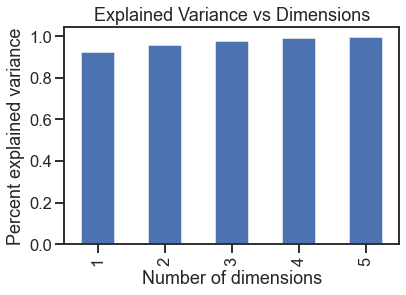

In [32]:
# Create a plot of explained variances.
sns.set_context('talk')
ax = pca_df['var'].plot(kind='bar')
ax.set(xlabel='Number of dimensions',
       ylabel='Percent explained variance',
       title='Explained Variance vs Dimensions');

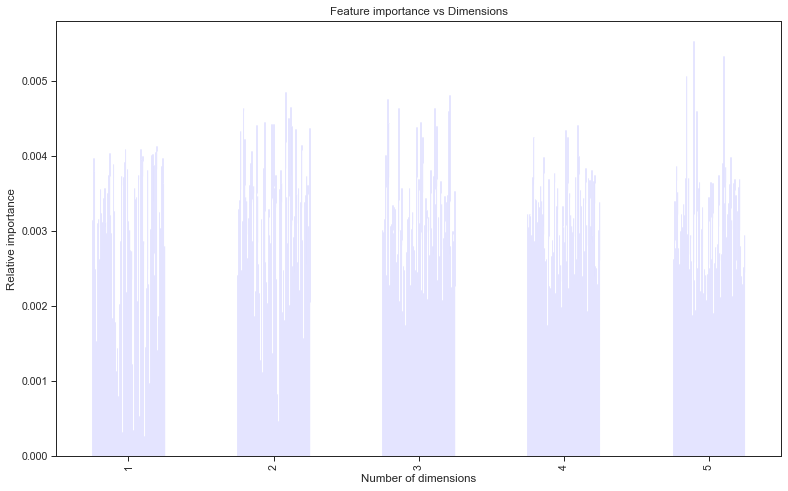

In [58]:
# Create a plot of feature importances.
ax = features_df.plot(kind='bar', figsize=(13,8),color='blue')
legend = ax.legend(bbox_to_anchor=(1.05, 1),loc='upper right')
legend.remove()
ax.set(xlabel='Number of dimensions',
       ylabel='Relative importance',
       title='Feature importance vs Dimensions');

The above figure reveals that for the numers of dimensions n_components=4, the relative importances of all elements are close to be similar values in contrast to other numers of dimensions, which show more importances for several particular elements but less importances for the rest. 

Text(0.5, 0, 'relative importance')

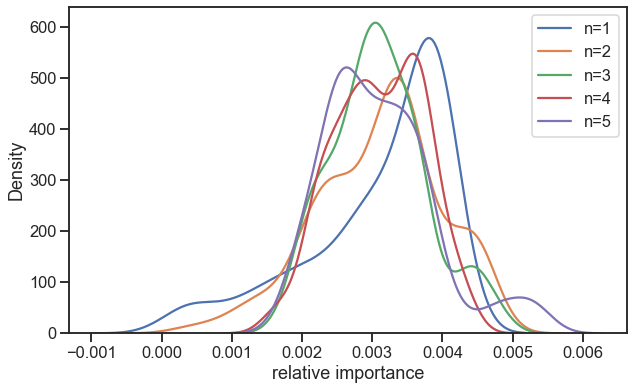

In [34]:
fig, ax=plt.subplots(figsize=(10,6))
ax=sns.kdeplot(features_df.iloc[0,],label='n=1')
ax=sns.kdeplot(features_df.iloc[1,],label='n=2')
ax=sns.kdeplot(features_df.iloc[2,],label='n=3')
ax=sns.kdeplot(features_df.iloc[3,],label='n=4')
ax=sns.kdeplot(features_df.iloc[4,],label='n=5')
ax.legend()
ax.set_xlabel('relative importance')

For n=3,4 and 5, the densities of relative importance are positive. Among the three cases, the densities of relative importance for n=4 are larger than the cases for n=3 and 5.  

In [35]:
# Custom scorer--use negative rmse of inverse transform
def scorer(pcamodel, X, y=None):
    try:
        X_val = X.values
    except:
        X_val = X        
    # Calculate and inverse transform the data
    data_inv = pcamodel.fit(X_val).transform(X_val)
    data_inv = pcamodel.inverse_transform(data_inv)    
    # The error calculation
    mse = mean_squared_error(data_inv.ravel(), X_val.ravel())    
    # Larger values are better for scorers, so take negative value
    return -1.0 * mse

In [36]:
# Fit a KernelPCA model with kernel='rbf'
# The grid search parameters
param_grid = {'gamma':[0.001, 0.01, 0.05, 0.1, 0.5, 1.0],
              'n_components': [2, 3, 4]}
# The grid search
kernelPCA = GridSearchCV(KernelPCA(kernel='rbf', fit_inverse_transform=True),
                         param_grid=param_grid,
                         scoring=scorer,
                         n_jobs=-1)
kernelPCA = kernelPCA.fit(stcorr_df6)
kernelPCA.best_estimator_

KernelPCA(fit_inverse_transform=True, gamma=0.1, kernel='rbf', n_components=4)

In [37]:
PCAmod = PCA(n_components=4)
pca_value=PCAmod.fit(stcorr_df6)
comp_pca=pd.DataFrame(np.transpose(pca_value.components_))
comp_pca.shape

(323, 4)

By fitting the KernelPCA model with grid search parameters, the result shows the best estimator with n=4. Therefore, in the following, we will use the first four principle components of the correlation matrix, i.e., the $323\times 4$ matrix comp_pca, for clustering.

## 5 Clustering models <a name="model"></a>

The $323\times 4$ matrix comp_pca contains 323 rows of road sections and 4 columns of the first four principle components of the correlation matrix as attributes. This section uses four methods for clustering and compares their clustering results:

* <a href="#kmeans">Section 5.1</a> fits the empirical data by K-Means models with Euclidean distances and evaluates the appropriate number of clusters by elbow method. 
* <a href="#hierarchical">Section 5.2</a> fits the empirical data by  an agglomerative hierarchical clustering model and show the result by a hierarchy dendrogram.
* <a href="#dbscan">Section 5.3</a> performs density-based spatial clustering of applications with noise (DBSCAN) for empirical data.
* <a href="#mean">Section 5.4</a> uses Mean shift model for clustering empirical data.
* <a href="#compare">Section 5.5</a> compares the results from four clustering methods with silhouette scores and show clusters resulting from each methods in a 3-dimensional space.

###  5.1 $k$-means clustering<a name="kmeans"></a>

In [38]:
from sklearn.cluster import KMeans
#!pip install kneed
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

In [39]:
# Create and fit a range of models
# use Euclidean distances
km_list = []
for clust in range(2,21):
    km = KMeans(n_clusters=clust, random_state=42).fit(comp_pca)
    km_list.append(km.inertia_)

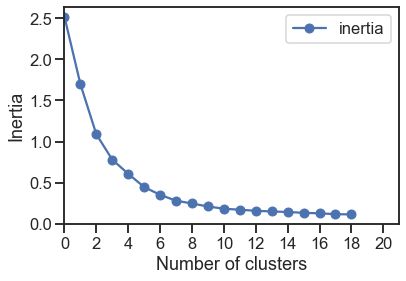

In [40]:
plot_data=pd.DataFrame(km_list, columns=['inertia'])
plot_data.rename_axis('cluster',axis=0)
ax = plot_data.plot(marker='o',ls='-')
ax.set_xticks(range(0,21,2))
ax.set_xlim(0,21)
ax.set(xlabel='Number of clusters', ylabel='Inertia');

In [41]:
# to evaluate the appropriate number of clusters, we use the elbow method. 
# An alternative method is the silhouette coefficient
kl = KneeLocator(range(2, 21), km_list, curve="convex", direction="decreasing")
kl.elbow

7

There’s a spot where the above curve starts to bend known as the **elbow point**. The x-value of this point is thought to be a reasonable trade-off between error and number of clusters. Therefore, we choose 7 as the optimal number of clusters.

The **silhouette coefficient** is a measure of cluster cohesion and separation. In the following, we use the silhouette coefficient to quantify how well a data point fits into its assigned cluster based on how close the data point is to other points in the cluster and how far away the data point is from points in other clusters. Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.

In [42]:
keans = KMeans(n_clusters=kl.elbow, random_state=42).fit(comp_pca)
label_kmeans=keans.labels_
score_kmeans = silhouette_score(comp_pca, keans.labels_)     
score_kmeans

0.5956759174332796

###  5.2 Hierarchical clustering<a name="hierarchical"></a>

In [43]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

In [44]:
# Hierarchical agglomerative clustering and silhouette score
agg = AgglomerativeClustering (n_clusters=kl.elbow, affinity='euclidean', linkage='ward').fit(comp_pca)
label_agg=agg.labels_
score_agg = silhouette_score(comp_pca, agg.labels_)     
score_agg

0.5841478255838047

Text(0, 0.5, 'distance')

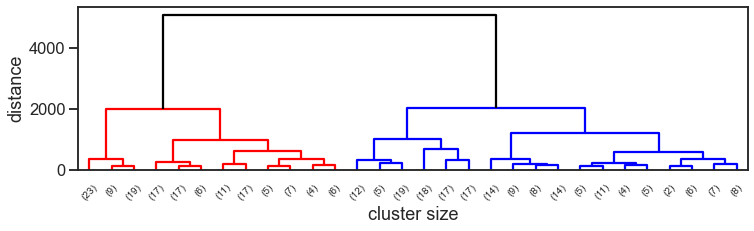

In [45]:
# draw hierarchy dendrogram
Z = hierarchy.linkage(agg.children_, method='ward')
fig, ax = plt.subplots(figsize=(12,3))
# Some color setup
hierarchy.set_link_color_palette(['red', 'blue'])
den = hierarchy.dendrogram(Z, orientation='top', 
                           p=30, truncate_mode='lastp',
                           show_leaf_counts=True, ax=ax,
                           above_threshold_color='black')
plt.xlabel('cluster size')
plt.ylabel('distance')

###  5.3 DBSCAN clustering<a name="dbscan"></a>

Three possible labels for any point with Density-Based Spatial Clustering of Applications with Noise (DBSCAN) :
* Core point: a point which has more than n_clu neighbors 
* Density-reachable or border points: a point that can be reached by a core point, but may have fewer than N_clu neighbors itself. 
* Noise point: a point that has no core points in its $\epsilon$-neighborhood.
Clusters connects core and density-reachable points.

DBSCAN Algorithm:
* Start at a random point. Look at the radius $\epsilon$ around that point. 
* If enough points n_clu within the circle, start a cluster. Every point within that $\epsilon$ is a part of the cluster. 
* Process each new point in the same way.
* If candidate point does not have n_clu neighbors within the radius $\epsilon$, it is density-reachable.
* Keep going until find the entire cluster and no point is left unvisited by this chain reaction. 
* If no neighbors left, randomly try a new (unvisited) point to potentially start a new cluster.
* Keep adding neighbours within $\epsilon$ as chain reaction. 
* If a point does not have n_clu neighbors and is not reached from a core point, it is a noise point, labeled as an outlier.



In [46]:
from sklearn.cluster import DBSCAN

In [47]:
# Density-Based Spatial Clustering of Applications with Noise (DBSCAN) with Euclidean distances
db_list = []
e_list=[]
for e in np.linspace(0.01,0.1,20):
    db=DBSCAN(eps=e,min_samples=2).fit(comp_pca)
    # eps: the maximum distance between two samples for one to be considered as in the neighborhood of the other. 
    label_db=db.labels_  # Cluster labels for each point in the dataset given to fit(). 
    label_db[label_db==-1]=max(label_db)+1   # Noisy samples are given the label -1.
    score_db = silhouette_score(comp_pca, label_db)     
    db_list.append(score_db)
    e_list.append(e)

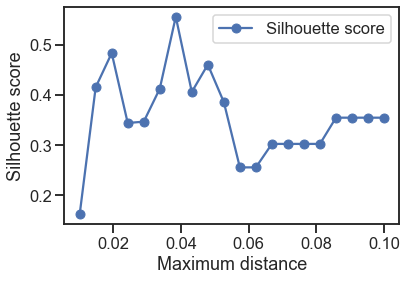

In [48]:
plot_data=pd.DataFrame({'maximum distance':e_list,'Silhouette score': db_list})
ax = plot_data.plot(x='maximum distance',y='Silhouette score', marker='o',ls='-')
ax.set(xlabel='Maximum distance', ylabel='Silhouette score');

In [49]:
# find the case with the maximal silhouette score
db_max=max(db_list)
max_idx_db=db_list.index(db_max)
max_idx_db

6

In [50]:
dbscan = DBSCAN(eps=e_list[max_idx_db]).fit(comp_pca)
label_dbscan=dbscan.labels_
label_dbscan[label_dbscan==-1]=max(label_dbscan)+1
score_dbscan = silhouette_score(comp_pca, label_dbscan)     
score_dbscan

0.5835014109432122

###  5.4 Mean shift clustering<a name="mean"></a>

The mean shift algorithm, working similarly to k-means, partition points according to their nearest cluster centroid.
1. Start a random point as a centroid and set a window size $W$ of a square area covering this point.
2. Calculate weighted mean of density within that window $W$ by 
3. Shift the centroid of the window to the new mean by gradient towards denser direction. 
4. Repeat steps 2 and 3 until convergence (no shift), i.e., until local density maximum ("mode") is reached. 
5. Repeat steps 1-4 for all data points.
6. Assign data points to centroids that they fall to. In other words, the data points that lead to the same mode are grouped into the same cluster. 

The weighted mean is calcualted by

$m(x)=\frac{\sum\limits_{x_i\in W}x_iK(x_i-x)}{\sum\limits_{x_i\in W}K(x_i-x)}$

where $x_i$ is the density of point $i$, $x$ is the previous mean, $m(x)$ is the new mean, $\sum\limits_{x_i\in W}$ means summing over points within window size (bandwidth) $W$, and $K(\cdot)$ is the weighting (kernel) function. 


In [51]:
from sklearn.cluster import MeanShift

In [52]:
w_list=[]
ms_list=[]
for w in np.linspace(0.01,0.1,10):
    ms=MeanShift(bandwidth=w).fit(comp_pca)
    label_ms=ms.labels_  # Cluster labels for each point in the dataset given to fit(). 
    score_ms = silhouette_score(comp_pca, label_ms)     
    ms_list.append(score_ms)
    w_list.append(w)

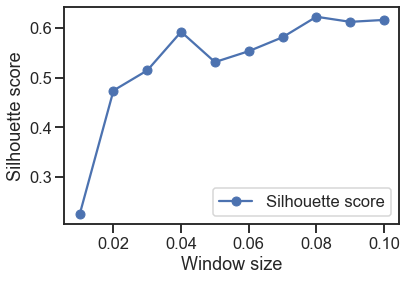

In [53]:
plot_data=pd.DataFrame({'Window size':w_list,'Silhouette score': ms_list})
ax = plot_data.plot(x='Window size',y='Silhouette score', marker='o',ls='-')
ax.set(xlabel='Window size', ylabel='Silhouette score');

In [54]:
# find the case with the maximal silhouette score
ms_max=max(ms_list)
max_idx_ms=ms_list.index(ms_max)
max_idx_ms

7

In [55]:
mshift=MeanShift(bandwidth=w_list[max_idx_ms]).fit(comp_pca)
label_mshift=mshift.labels_  # Cluster labels for each point in the dataset given to fit(). 
score_mshift = silhouette_score(comp_pca, label_mshift)   
score_mshift

0.6227191412173007

###  5.5 Comparison of clustering methods<a name="compare"></a>

Text(0.5, 0.92, 'Mean shift clustering')

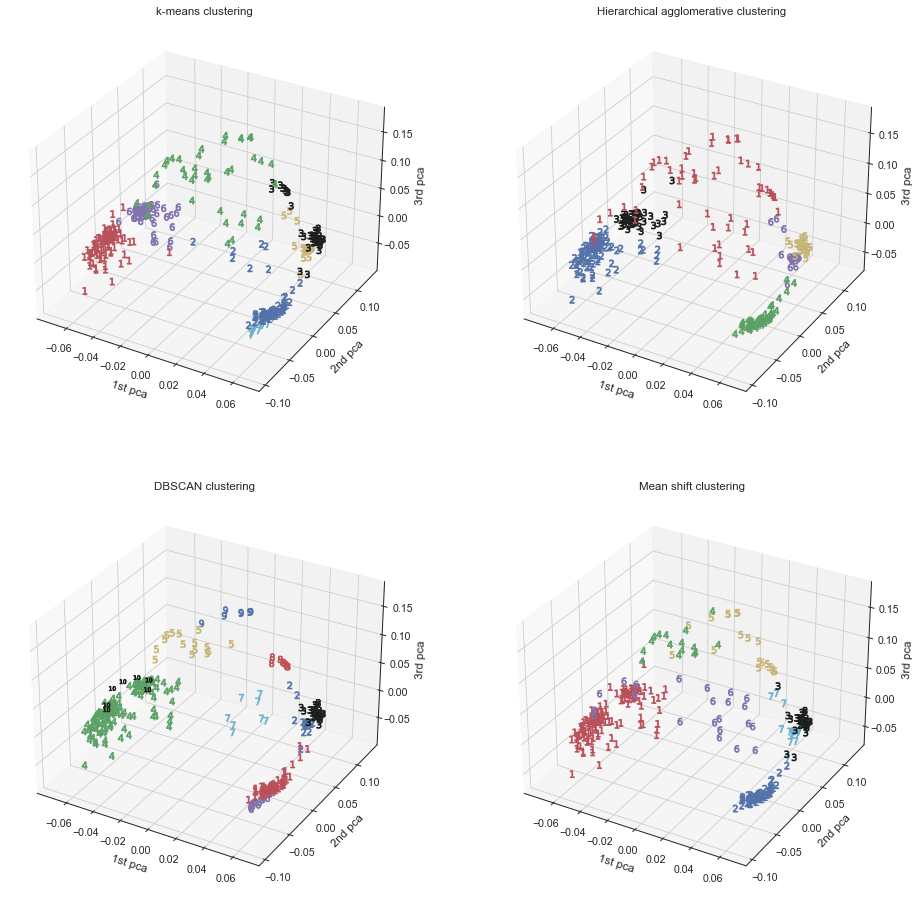

In [56]:
color=['r','b','k','g','y','m','c','r','b','k','g','y','m','c','r']
sns.set_context("paper", font_scale=1.2)
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax3 = fig.add_subplot(2, 2, 3, projection='3d')
ax4 = fig.add_subplot(2, 2, 4, projection='3d')

# k-means clustering
for i in range(7):
    idx=np.where(label_kmeans == i)[0]
    ax1.scatter(comp_pca.iloc[idx,0], comp_pca.iloc[idx,1], comp_pca.iloc[idx,2], marker='$%d$' % (i+1), alpha=1,
                    s=50, edgecolor=color[i])
ax1.set_xlabel('1st pca')
ax1.set_ylabel('2nd pca')
ax1.set_zlabel('3rd pca')
ax1.set_title('k-means clustering')

# Hierarchical agglomerative clustering
for i in range(0,max(label_agg)):
    idx=np.where(label_agg == i)[0]
    ax2.scatter(comp_pca.iloc[idx,0], comp_pca.iloc[idx,1], comp_pca.iloc[idx,2], marker='$%d$' % (i+1), alpha=1,
                    s=50, edgecolor=color[i])
ax2.set_xlabel('1st pca')
ax2.set_ylabel('2nd pca')
ax2.set_zlabel('3rd pca')
ax2.set_title('Hierarchical agglomerative clustering')

# DBSCAN clustering
for i in range(0,max(label_dbscan)):
    idx=np.where(label_dbscan == i)[0]
    ax3.scatter(comp_pca.iloc[idx,0], comp_pca.iloc[idx,1], comp_pca.iloc[idx,2], marker='$%d$' % (i+1), alpha=1,
               s=50, edgecolor=color[i])
ax3.set_xlabel('1st pca')
ax3.set_ylabel('2nd pca')
ax3.set_zlabel('3rd pca')
ax3.set_title('DBSCAN clustering')

# Mean shift clustering
for i in range(0,max(label_mshift)):
    idx=np.where(label_mshift == i)[0]
    ax4.scatter(comp_pca.iloc[idx,0], comp_pca.iloc[idx,1], comp_pca.iloc[idx,2], marker='$%d$' % (i+1), alpha=1,
               s=50, edgecolor=color[i])
ax4.set_xlabel('1st pca')
ax4.set_ylabel('2nd pca')
ax4.set_zlabel('3rd pca')
ax4.set_title('Mean shift clustering')


[Text(0, 0.5, 'Scores')]

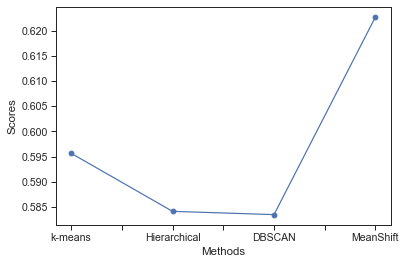

In [57]:
sil_score=pd.DataFrame({'Methods':['k-means','Hierarchical','DBSCAN','MeanShift'],'Scores':[score_kmeans,score_agg,
                        score_dbscan, score_mshift]})
sil_score.plot(x='Methods',y='Scores',marker='o',legend=False).set(ylabel='Scores')

## 6 Summary <a name="summary"></a>

This study used the data of traffic flows from 323 counting stations with regard to 18 attributes. Data cleaning and feature engineering make the raw data available. In particular, a logarithmical transformation was performed for the attributes with large skew values. We worked out a $323\times 323$ correlation matrix with processed data. The correlation matrix shows significant correlation structures both before and after logarithmical transformation, but the latter are more obvious.

We performed the principle component analysis (PCA) for the dimensonal reduction of the correlation matrix. The first four principle components was considered so that the data matrix for clustering has the dimensions of $323\times 4$. 

We applied four methods to clustering road sections, indicated by counting stations. The four methods are $k$-means clustering, Hierarchical agglomerative clustering, DBSCAN clustering and Mean shift clustering. For each method, we calculated the silhouette values which measures the cluster cohesion and separation. Using silouette values as the evalution of the clustering quality, we further compared the four methods. The results shows that the mean shift clustering among the four methods fits our data best. The difference of the four methods with respect to the cluster cohesion and separation is also visible in a 3-dimensional space for the first three principle components, where the $k$-means clustering and mean shift clustering show the better separations for clusters than the other two methods.  

## 7 Suggestions for next steps<a name="suggestion"></a>

The above study compared the four clustering methods by silhouette scores. A futher step can be done by spliting the data set into a training and a testing data set. The training data set can be clustered by the four methods. Instead of the silhouette scores, the testing data set can be used to evaluate the clustering quality. The best methods with the parameters resulting from training the model then can be used for predicting the cluster that the unclassified data points belong to. 